Analysis of unrestrained trajectories.

Based on `p20201102a_free.ipynb`.

And borrowing some stuff from:

- `p20201130b_wdens_dlocal_pmf.ipynb`
- `zeolites` repo `p20201203a_plots.ipynb`

## Setup

In [1]:
import os
import os.path as osp

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
from datetime import datetime

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

In [7]:
# mpl.rcParams['figure.dpi']= 300

In [8]:
mpl.rcParams['xtick.labelsize']="large"
mpl.rcParams['ytick.labelsize']="large"

In [9]:
from collections import namedtuple

In [10]:
from scipy.optimize import curve_fit

## Constants

In [11]:
input_fname="920_msd.csv.xz"

In [12]:
tag_list=["01","02","03"]

In [13]:
coordcols=['xsq','ysq','zsq']

In [14]:
framenames=["A","B","C"]

In [15]:
frametags=dict(zip(tag_list,framenames))
frametags

{'01': 'A', '02': 'B', '03': 'C'}

In [16]:
plot_fname="msd_plot.png"

In [17]:
presplot_fname="msd_presplot.png"

In [18]:
outdata_fname="D_from_msd.yaml"

## Data file paths

In [19]:
top_folder="../jobs/run/bulk03"

In [20]:
infpaths={tag:osp.join(top_folder,tag,input_fname) for tag in tag_list}

In [21]:
exist_dict={tag:osp.isfile(fpath) for tag,fpath in infpaths.items()}
exist_dict

{'01': True, '02': True, '03': True}

In [22]:
assert all(exist_dict.values())

## Output data folder and paths

In [23]:
outdir_top="../postproc/from_notebooks"
assert osp.isdir(outdir_top)

In [24]:
datestr=datetime.now().strftime("%Y_%m_%d")
datestr

'2020_12_04'

In [25]:
outdir=osp.join(outdir_top,datestr)

In [26]:
if not osp.isdir(outdir):
  os.makedirs(outdir)
assert osp.isdir(outdir)

In [27]:
plot_fpath=osp.join(outdir,plot_fname)
presplot_fpath=osp.join(outdir,presplot_fname)

In [28]:
outdata_fpath=osp.join(outdir,outdata_fname)

## Load data

In [29]:
trajframes={tag:pd.read_csv(fpath) for tag,fpath in infpaths.items()}

In [30]:
trajframes[tag_list[0]].columns

Index(['t', 'x', 'y', 'z', 'xsq', 'ysq', 'zsq'], dtype='object')

In [31]:
trajframes[tag_list[0]].shape

(800001, 7)

## Create dataframe with sum of squared deviations for each trial

In [32]:
framecols=['t','t_ns']+framenames

In [33]:
def do_ns(row):
  return row['t']/1000.0

In [34]:
newframe=pd.DataFrame(trajframes[tag_list[0]].loc[:,'t'],columns=framecols)
newframe['t_ns']=newframe.apply(do_ns,axis=1)
for col in framenames:
  newframe[col]=0

In [35]:
newframe.loc[1000,:]

t       20.00
t_ns     0.02
A        0.00
B        0.00
C        0.00
Name: 1000, dtype: float64

In [36]:
for col in coordcols:  
  for tag,df in trajframes.items():
    newframe.loc[:,frametags[tag]] += df.loc[:,col]

In [37]:
newframe.loc[1000,:]

t       20.000000
t_ns     0.020000
A        0.633664
B        0.119345
C        0.442439
Name: 1000, dtype: float64

## Plots

In [38]:
framecolors={"A":"r","B":"g","C":"b"}

In [39]:
def plot_3msd_frames(df,cutoff=-1,suffix="",ylabel="Radial Mean Squared Deviation [nm$^2$]",lines=None,fpath=None):
  fig,ax=plt.subplots(figsize=(8,6))
  for frame,color in framecolors.items():
    o=ax.plot(df['t_ns'][:cutoff],df[frame+suffix][:cutoff],color+'-',label=frame)
  for frame,color in framecolors.items():
    if lines is not None:
      m=lines[frame]
      tmax=df.iloc[cutoff,1]
      o=ax.plot([0,tmax],[0,m*tmax],color+"--",label="%s fit"%frame)
  o=ax.set_xlabel("time [nsec]",fontsize=16)
  o=ax.set_ylabel(ylabel,fontsize=16)
  o=ax.legend(loc="upper left",fontsize=16)
  if fpath is not None:
    fig.savefig(fpath,dpi=150)
  return

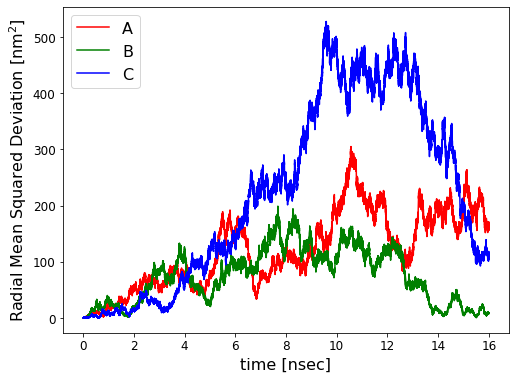

In [40]:
plot_3msd_frames(newframe)

## Fit line(s)

In [41]:
def fitfunc(t,m):
  return m*t

In [42]:
arg_order=['m']
fitparams=namedtuple('fitparams',arg_order)
errortup=fitparams(*[None for itm in arg_order])

In [43]:
results_dict={}
perrs_dict={}
tdata=newframe['t_ns']
for fn in framenames:
  try:
    popt,pcov=curve_fit(fitfunc,tdata,newframe[fn])
    results_dict[fn]=fitparams(*popt)
    perrs_dict[fn]=fitparams(*np.sqrt(np.diag(pcov)))
  except RuntimeError:
    results_dict[fn]=errortup
    perrs_dict[fn]=errortup

In [44]:
results_dict

{'A': fitparams(m=14.348511884147117),
 'B': fitparams(m=7.261509889413928),
 'C': fitparams(m=27.041937974384467)}

In [45]:
perrs_dict

{'A': fitparams(m=0.005036469087934094),
 'B': fitparams(m=0.007020390131802154),
 'C': fitparams(m=0.013589119654315238)}

In [46]:
Dvals_dict={}
for fn in framenames:
  Dvals_dict[fn]=results_dict[fn].m/6.0

In [47]:
Dvals_dict

{'A': 2.391418647357853, 'B': 1.2102516482356547, 'C': 4.5069896623974115}

In [48]:
lines={fn:results_dict[fn].m for fn in framenames}

## Plot with fits

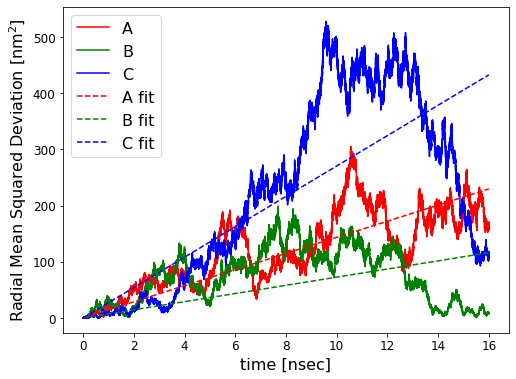

In [49]:
plot_3msd_frames(newframe,lines=lines,fpath=plot_fpath)

In [50]:
def plot_3msd_frames_pres(df,cutoff=-1,suffix="",
                          ylabel="Radial MSD",lines=None,fpath=None):
  fig,ax=plt.subplots(figsize=(4,3))
  for frame,color in framecolors.items():
    o=ax.plot(df['t_ns'][:cutoff],df[frame+suffix][:cutoff],color+'-',label=frame)
  for frame,color in framecolors.items():
    if lines is not None:
      m=lines[frame]
      tmax=df.iloc[cutoff,1]
      o=ax.plot([0,tmax],[0,m*tmax],color+"--",label="%s fit"%frame)
  o=ax.set_xlabel("time",fontsize=20)
  o=ax.set_ylabel(ylabel,fontsize=20)
  o=ax.set_xticks([])
  o=ax.set_yticks([])
  ##o=ax.legend(loc="upper left",fontsize=16)
  if fpath is not None:
    fig.savefig(fpath)
  return

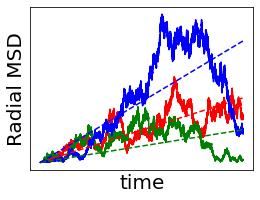

In [51]:
plot_3msd_frames_pres(newframe,lines=lines,fpath=presplot_fpath)

## Write D values to file

In [52]:
with open(outdata_fpath,"w") as fp:
  fp.write("%YAML 1.2\n---\n")
  fp.write("#D in units of nm^2/nsec\n")
  for fn,Dval in Dvals_dict.items():
    fp.write("{fn}: {Dval}\n".format(fn=fn,Dval=Dval))